In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [25]:
from zipfile import ZipFile
file_name = '/content/fruit.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [27]:
data_dir = '/content/fruit'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training")
print('131 classes :', classes)

Folders : ['training', 'test']
2 classes : ['apple', 'orange']


In [28]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
print('Size of training dataset :', len(dataset))
test = ImageFolder(data_dir + '/Test', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of training dataset : 198
Size of test dataset : 66


In [29]:
img, label = dataset[1000]
print(img.shape)

torch.Size([3, 100, 100])


Label:  orange (2)


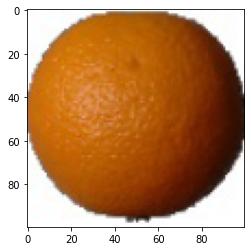

In [30]:
def show_image(img, label):
  print('Label: ', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1, 2, 0))
show_image(img, label)

In [31]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(dataset) / batch_size)
num_epochs = int(num_epochs)

In [36]:
# data loader
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)

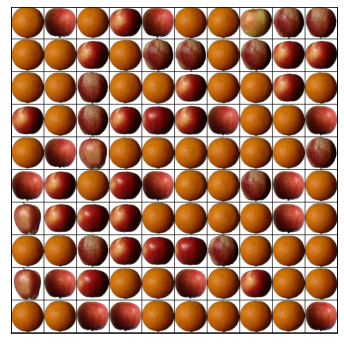

In [40]:
from torchvision.utils import make_grid
for images, labels in train_loader:
  fig, ax = plt.subplots(figsize=(6,6))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
  break

In [42]:
class ANNModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(ANNModel, self).__init__()
    # Linear function 1: 30000 --> 150
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    # Non-linearity 1
    self.relu1 = nn.ReLU()
    # Linear function 2: 150 --> 150
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    # Non-linearity 2 : Tanh
    self.tanh2 = nn.Tanh()
    # Linear function 3: 150 --> 150
    self.fc3 = nn.Linear(hidden_dim, hidden_dim)
    # Non-linearity 3 ReLU
    self.relu3 = nn.ELU()
    self.fc4 = nn.Linear(hidden_dim, output_dim)
  def forward(self, x):
    # Linear function 1
    out = self.fc1(x)
    # Non-linearity 1
    out = self.relu1(out)
    # Linear function 2
    out = self.fc2(out)
    # Non-linearity 2
    out = self.tanh2(out)
    # Linear function 2
    out = self.fc3(out)
    # Non-linearity 2
    out = self.relu3(out)
    # Linear function 4 (readout)
    out = self.fc4(out)
    return out
# instantiate ANN
input_dim = 3*100*100

#hidden layer dim is one of the hyper parameter and it should be chosen and tuned.
hidden_dim = 150
output_dim = 131
# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)
# Cross Entropy Loss
error = nn.CrossEntropyLoss()
# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [45]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    train = Variable(images.view(-1, 3*100*100))
    labels = Variable(labels)
    # Clear gradients
    optimizer.zero_grad()
    # Forward propagation
    outputs = model(train)
    # Calculate softmax and cross entropy loss
    loss = error(outputs,labels)
    # Calculating gradients
    loss.backward()
    # Update parameters
    optimizer.step()
    count += 1
    if count % 50 == 0:
      # Calculate Accuracy
      correct = 0
      total = 0
      # Predict test dataset
      for images, labels in test_loader:
        test = Variable(images.view(-1, 3*100*100))
        # Forward propagation
        outputs = model(test)
        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
        # Total number of labels
        total += len(labels)
        # Total correct predictions
        correct += (predicted == labels).sum()
      accuracy = 100 * correct / float(total)
      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)
    if count % 500 == 0:
      # Print Loss
      print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500 Loss: 0.00021877088875044137 Accuracy: 0.0 %
Iteration: 1000 Loss: 0.0001710641518002376 Accuracy: 0.0 %
Iteration: 1500 Loss: 0.00013871051487512887 Accuracy: 0.0 %
Iteration: 2000 Loss: 0.00011792338773375377 Accuracy: 0.0 %
Iteration: 2500 Loss: 9.310636232839897e-05 Accuracy: 0.0 %


KeyboardInterrupt: ignored

In [ ]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

In [ ]:
# visualization accuracy
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()